# CycleGAN

#1. 사전 단계

Pix2Pix의 generator와 discriminator를 가져올 수 있는 패키지 설치 https://github.com/tensorflow/examples.*git*

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-fyeay7wr
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-fyeay7wr


필요한 라이브러리 import

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
import os
import time
from matplotlib import pyplot as plt
from IPython.display import clear_output
AUTOTUNE = tf.data.AUTOTUNE

구글 드라이브와 mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#2. 데이터 경로 지정

photo train & test

In [1]:
train_photo= tf.data.Dataset.list_files("/content/drive/MyDrive/ganchanh/gan-getting-started/photo_jpg/*.jpg")
test_photo= tf.data.Dataset.list_files("/content/drive/MyDrive/ganchanh/gan-getting-started/photo_jpg/*.jpg")

NameError: ignored

style train  & test

In [ ]:
train_style = tf.data.Dataset.list_files("/content/drive/MyDrive/ganchanh/data/images/images/Paul_Cezanne/*.jpg")
test_style = tf.data.Dataset.list_files("/content/drive/MyDrive/ganchanh/data/images/images/Paul_Cezanne/*.jpg")

#3. 전처리

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
#이미지를 load
def load(image_file): 
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  image = image[:, w:, :]

  image = tf.cast(image, tf.float32)


  return image

In [ ]:
#사이즈 재정의 해주는 함수
def resize(image, height, width): 
  image = tf.image.resize(image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return image

In [ ]:
# 이미지의 특정 부위를 랜덤하게 crop
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [ ]:
#이미지 값을 [-1,1]사이의 값으로 정규화
def normalize(image):
  image = tf.cast(image, tf.float32)#이미지를 float 형태로 바꿔줌
  image = (image / 127.5) - 1
  return image

In [ ]:
#jittering :  전처리를 이용해 이미지에 변형을 주어 데이터를 증강 시키는 기법
@tf.function()
def random_jitter(image):
  # resize 함수 이용: 이미지를 286 x 286 x 3로 바꿔줌
  image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  # random_crop 함수 이용: 랜덤 crop
  image = random_crop(image)
  # image.random_flip_left_right함수 이용: 랜덤 좌우 반전
  image = tf.image.random_flip_left_right(image)

  return image

train 이미지 전처리

In [ ]:
#resize, random crop, mirroring, normalize
def preprocess_image_train(image_file):
  image = load(image_file)
  image = random_jitter(image) 
  image = normalize(image) 

  return image

test 이미지 전처리

In [ ]:
#resize, normalize
def preprocess_image_test(image_file):
  image = load(image_file)
  image = resize(image,IMG_HEIGHT, IMG_WIDTH)
  image = normalize(image)

  return image

#4. 맵핑

In [ ]:
#cache는 처음 불러온 데이터를 저장해놓고, 이후 필요하면 저장된 데이터를 불러다가 쓰는 방식
#shuffle, batch 진행
train_photo = train_photo.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train_style = train_style.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_photo = test_photo.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_style = test_style.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#5. 샘플 지정

In [ ]:
sample_style = next(iter(train_style))

In [ ]:
sample_photo = next(iter(train_photo))

photos 랜덤 출력 (원본, 전처리 후)

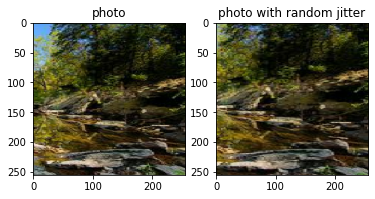

In [ ]:
plt.subplot(121)
plt.title('photo')
plt.imshow(sample_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('photo with random jitter')
plt.imshow(random_jitter(sample_photo[0]) * 0.5 + 0.5)

style 랜덤 출력 (원본, 전처리 후)

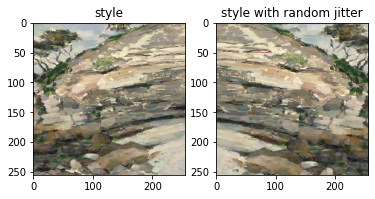

In [ ]:
plt.subplot(121)
plt.title('style')
plt.imshow(sample_style[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('style with random jitter')
plt.imshow(random_jitter(sample_style[0]) * 0.5 + 0.5)

# 6.  Generator(생성기)와 Discriminator(판별기)

- Pix2Pix에서 사용된 generator와 discriminator를 가져옴

- Pix2Pix와의 차이점

  - CycleGAN은 [batch normalization](https://arxiv.org/abs/1502.03167) 대신 [instance normalization](https://arxiv.org/abs/1607.08022)사용

  - 논문에서는 ResNet기반 생성기를 사용하지만 본 코드에서는 UNet 생성기를 기반으로 함



  - generator_g 는 이미지 `X`를 이미지 `Y`로 변환하는 방법을 학습 $(G : X -> Y)$

  - generator_f는 이미지 `Y`를 이미지 `X`로 변환하는 방법을 학습 $(F : Y -> X)$

  - discriminator_x (Dx) 는 이미지 `X`와 생성 된 이미지 `X`( `F(Y)` )를 구별하는 방법을 학습

  -  discriminator_y (Dy) 는 이미지 `Y`와 생성 된 이미지 `Y`( `G(X)` )를 구별하는 `D_Y` 학습

  <img src="https://www.tensorflow.org/tutorials/generative/images/cyclegan_model.png">

generator, discriminator 훈련

In [ ]:
OUTPUT_CHANNELS = 3
#pix2pix의 unet의 generator 사용, instance normalization 사용
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm') # X->Y
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm') # Y->X

#pix2pix의 unet의 discriminaotr 사용, instance normalization 사용
discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False) # X와 X(F(Y))를 구별
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False) # Y와 Y(G(X))를 구별

generator 테스트

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


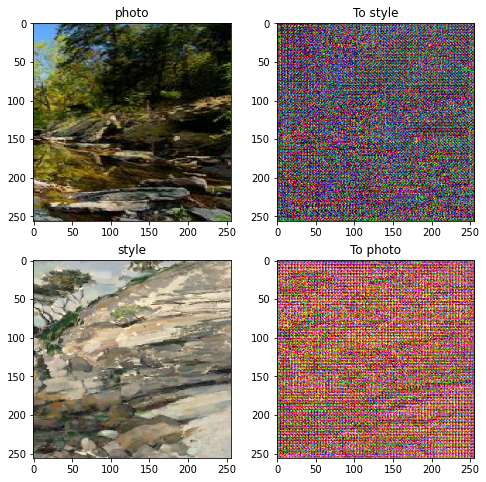

In [ ]:
#generator_g // X: photo -> Y: style로 바꿔줌
to_style = generator_g(sample_photo)
#generator_f// Y: style-> X: photo로 바꿔줌
to_photo = generator_f(sample_style)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_photo, to_style, sample_style, to_photo]
title = ['photo', 'To style', 'style', 'To photo']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

discriminator 테스트

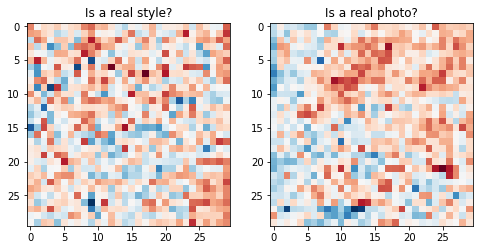

In [ ]:
plt.figure(figsize=(8, 8))
# Y: style과  생성 된 이미지 Y(G(X))를 구별
plt.subplot(121)
plt.title('Is a real style?')
plt.imshow(discriminator_y(sample_style)[0, ..., -1], cmap='RdBu_r')

#X: photo과  생성 된 이미지 X(F(Y))를 구별
plt.subplot(122)
plt.title('Is a real photo?')
plt.imshow(discriminator_x(sample_photo)[0, ..., -1], cmap='RdBu_r')

plt.show()

#7. Loss functions (손실함수)
- CycleGAN에서는 학습 할 쌍데이터가 없으므로 입력 `x` 및 대상 `y` 쌍이 학습 중에 의미가 있다는 보장이 없음  

- 따라서 네트워크가 올바른 매핑을 학습하도록하기 위해 논문 저자는 주기 일관성 손실을 제안

- G(x)로 나온 y값을 다시 F(y)를 통해 원본 이미지로 복원한다.
- F(y)로 나온 x값을 다시 G(x)를 통해 y로 복원한다. 

이 원리를 이용해서 전체 손실 함수를 정의한다.

(discriminator loss와 generator loss는 pix2pix 에서 사용되는 것과 유사)

In [ ]:
LAMBDA = 10

In [ ]:
#Binary_Crossentropy: 손실 함수(내가 가진 label 값이 0 or 1(참 또는 거짓)이고 sigmoid_cross_entropy를 loss로 하고 싶을때 사용)
# discriminator의 판단값은 0~1 사이의 확률값이므로 BinaryCrossentropy사용
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

discriminator_loss함수

In [ ]:
# 실제 이미지Y에 대한 판별값과 생성 이미지X에 대한 판별값을 받아들여서 진짜 가짜 구별
# 실제 이미지Y는 1로 생성이미지X는 0으로 판단하길 원함 -> 맞게 판단 되면 loss를 줄임
# real_loss와 generated_loss의 합으로 이루어짐 
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5 #비율을 맞추기 위해 0.5곱함(논문상 구현)

generator_loss 함수

In [ ]:
#생성이미지가 1로 판단 되길 원함
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

## 주기 일관성

- 결과가 원래 입력에 가까워 야 함을 의미

ex. 한국어-> 영어-> 한국어 (결과=입력) 

- 주기 일관성 손실에서

  - $X$이미지는 생성 된 $hatY$이미지를 생성하는 $G$생성기를 통해 전달

  - 생성 된 이미지 $hatY$는 순환 이미지 $hatX$을 생성하는 생성기 $F$를 통해 전달

  - 평균 절대 오차는 $X$와 $hatX$사이에서 계산됨
  
  $\quad forward\ cycle\ consistency\ loss: X -> G(X) -> F(G(X)) \sim \hat{X}$

  $\quad backward\ cycle\ consistency\ loss: Y -> F(Y) -> G(F(Y)) \sim \hat{Y}$

  <img src="https://www.tensorflow.org/tutorials/generative/images/cycle_loss.png">

calc_cycle_loss 함수

In [ ]:
# cycled_image(복구한 입력 이미지)와 real_image(실제 입력 이미지)의 차를 행단위로 평균냄
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

Identity_loss 함수


$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$


In [ ]:
# 기본적인 loss와 별도로, 각 Gen의 성능을 높이기 위한 것
# x를 넣어서 y가 나오는 것이 아니라, 그냥 x를 넣어서 x가 나오도록 Generator를 학습시키는 용도
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

- 모든 생성기와 판별기에 대한 옵티마이저 초기화 (Adam optimizer 사용)

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

#8. Checkpoints

In [ ]:
# 각 모델들과 옵티마이저에 대해 체크포인트 객체를 만듬
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)
#위에서 만든 체크포인트, 경로, 최대 저장 개수 입력하여 매니저 객체 만듦
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5) 

# 만약 latest 체크포인트가 존재한다면 그것에서부터 restore를 하도록 처리
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [ ]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %profile  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %shell  %store  %sx  %system  %tb  %tensorflow_version  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%bigquery  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%perl 

#9. Training


In [ ]:
EPOCHS = 1
#1

In [ ]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy.random import random
from scipy.linalg import sqrtm

In [ ]:
# calculate frechet inception distance
def calculate_fid(act1, act2):
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

In [ ]:
#이미지 출력
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

- 학습 과정 
  
  1. 예측을 가져옴

  2. loss 계산

  3. 역전파를 사용하여 기울기(gradient) 계산

  4. 옵티마이저에 그라디언트를 적용

  
   <img src="https://www.tensorflow.org/tutorials/generative/images/cycle_loss.png">

In [ ]:
@tf.function
def train_step(real_x, real_y):
  #gradient계산 위함
  with tf.GradientTape(persistent=True) as tape:     
    #generator_g에서 나온 결과, Generator G translates X -> Y
    fake_y = generator_g(real_x, training=True) 
    #generator_f에 fake_y를 넣어서 나온 결과, hatx
    cycled_x = generator_f(fake_y, training=True)

    #generator_f에서 나온 결과, Generator F translates Y -> X. 
    fake_x = generator_f(real_y, training=True)
    #generator_g에 fake_x를 넣어서 나온 결과, haty
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y는 identity loss에서 사용됨
    # generator_f에 real_x를 넣은게 same_x
    same_x = generator_f(real_x, training=True)
    # generator_g에 real_y를 넣은게 same_x
    same_y = generator_g(real_y, training=True)

    #discriminator_x에 real_x를 넣었을 때
    disc_real_x = discriminator_x(real_x, training=True)
    #discriminator_y에 real_y를 넣었을 때
    disc_real_y = discriminator_y(real_y, training=True)
    #discriminator_x에 fake_x를 넣었을 때
    disc_fake_x = discriminator_x(fake_x, training=True)
    #discriminator_y에 fake_y를 넣었을 때
    disc_fake_y = discriminator_y(fake_y, training=True)


    #disc_fake_y는 x를 generator_g를 통해 haty로 바꾸었을 때 discriminator_y가 측정한 loss
    gen_g_loss = generator_loss(disc_fake_y)
    #disc_fake_x는 y를 generator_f를 통해 hatx로 바꾸었을 때 dicriminator_x가 측정한 loss
    gen_f_loss = generator_loss(disc_fake_x)
   
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  # gradients
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # optimizer
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

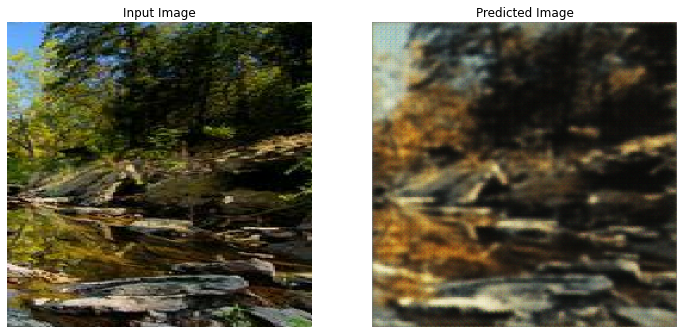

Time taken for epoch 1 is 146.97030115127563 sec



In [ ]:
# 설정한 에폭만큼 반복
for epoch in range(EPOCHS):
  start = time.time()
  
# 데이터셋에서 학습 데이터인 풍경 사진과 화풍 사진을 가져와 train_step에 넣어줌 
  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_photo, train_style)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print (n)
    n += 1

  clear_output(wait=True)

  generate_images(generator_g, sample_photo)

  if (epoch + 1) % 5 == 0: #에포크가 5의 배수 일때 마다 체크 포인트 메니저로 save 후 로깅
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

#10. Generate using test dataset

In [ ]:
# Run the trained model on the test dataset
for inp in test_photo.take(5):
  generate_images(generator_g, inp)

Output hidden; open in https://colab.research.google.com to view.

#11. segmentation


##google vision api

In [ ]:
import os 
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/content/drive/MyDrive/ganchanh/data/my_photos/ringed-reserve-322015-d043663d24a9.json'

In [ ]:
!pip install --upgrade google-cloud-vision

     |████████████████████████████████| 369 kB 7.8 MB/s 
     |████████████████████████████████| 42 kB 2.0 MB/s 


##label detection

In [ ]:
import io 
import os 
# Imports the Google Cloud client library 
from google.cloud import vision 

# Instantiates a client 
client = vision.ImageAnnotatorClient() 

# The name of the image file to annotate 
file_name = os.path.abspath('/content/drive/MyDrive/ganchanh/data/my_photos/4.jpeg') 

# Loads the image into memory 
with io.open(file_name, 'rb') as image_file:
    content = image_file.read() 

image = vision.Image(content=content) 

# Performs label detection on the image file 
response = client.label_detection(image=image) 
labels = response.label_annotations 
 
print('Number of Labels found: {}\n'.format(len(labels)))
for label in labels: 
    print(label.description)

Number of Labels found: 10

Water
Cloud
Smile
Sky
Flash photography
Happy
Gesture
People in nature
Travel
Gown


##object detection
좌표값을 얻을 수 있음.

In [ ]:
import io 
import os 
# Imports the Google Cloud client library 
from google.cloud import vision 
# Instantiates a client 
client = vision.ImageAnnotatorClient() 
# The name of the image file to annotate 
file_name = os.path.abspath('/content/drive/MyDrive/ganchanh/data/my_photos/4.jpeg')

# Loads the image into memory 
with io.open(file_name, 'rb') as image_file:
    content = image_file.read() 

image = vision.Image(content=content) 

objects = client.object_localization(image=image).localized_object_annotations

print('Number of objects found: {}'.format(len(objects)))
for object_ in objects:
    print('\n{} (confidence: {})'.format(object_.name, object_.score))
    print('Normalized bounding polygon vertices: ')
    for vertex in object_.bounding_poly.normalized_vertices:
        print(' - ({}, {})'.format(vertex.x, vertex.y))


Number of objects found: 2

Person (confidence: 0.7796503305435181)
Normalized bounding polygon vertices: 
 - (0.0014795772731304169, 0.36439672112464905)
 - (0.9928606152534485, 0.36439672112464905)
 - (0.9928606152534485, 0.993594765663147)
 - (0.0014795772731304169, 0.993594765663147)

Top (confidence: 0.6511780023574829)
Normalized bounding polygon vertices: 
 - (0.03032749891281128, 0.5640714764595032)
 - (0.9663854241371155, 0.5640714764595032)
 - (0.9663854241371155, 0.997023344039917)
 - (0.03032749891281128, 0.997023344039917)


##  detection한 사진 출력해보기
(gan을 적용하지 않은 예시임)

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

Number of objects found: 4 

Flower (confidence: 0.8879501223564148)

Normalized bounding polygon vertices: 
Flower (confidence: 0.8828485608100891)

Normalized bounding polygon vertices: 
Flower (confidence: 0.8685734272003174)

Normalized bounding polygon vertices: 
Flower (confidence: 0.8681064248085022)

Normalized bounding polygon vertices: 
x[]:  [0.3152789771556854, 0.6325913071632385, 0.6325913071632385, 0.3152789771556854, 0.45055636763572693, 0.7443097233772278, 0.7443097233772278, 0.45055636763572693, 0.21921420097351074, 0.5096026062965393, 0.5096026062965393, 0.21921420097351074, 0.33240124583244324, 0.6605732440948486, 0.6605732440948486, 0.33240124583244324]
y[]:  [0.7682671546936035, 0.7682671546936035, 0.964721143245697, 0.964721143245697, 0.6237547993659973, 0.6237547993659973, 0.8282339572906494, 0.8282339572906494, 0.5905657410621643, 0.5905657410621643, 0.7694526314735413, 0.7694526314735413, 0.49131298065185547, 0.49131298065185547, 0.6303136944770813, 0.630313694

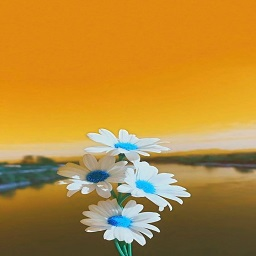

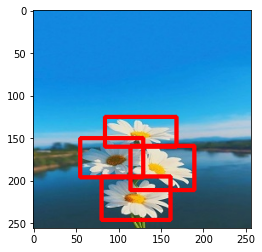

In [ ]:
#여기는 google cloud vision
import io 
import os 
from google.cloud import vision 
client = vision.ImageAnnotatorClient() 
file_name = os.path.abspath('/content/drive/MyDrive/ganchanh/data/my_photos/1.jpeg')  #이미지 경로설정

image_test=tf.data.Dataset.list_files(('/content/drive/MyDrive/ganchanh/data/my_photos/1.jpeg') )
image_test = image_test.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

#x와 y 좌표를 넣을 리스트를 만듬
x=[]
y=[]

# Loads the image into memory 
with io.open(file_name, 'rb') as image_file:
    content = image_file.read() 
image = vision.Image(content=content)
objects = client.object_localization(image=image).localized_object_annotations
 
print('Number of objects found: {} \n'.format(len(objects))) #찾아진 object의 수
for object_ in objects: 
    print('{} (confidence: {})\n'.format(object_.name, object_.score)) #object이름이랑 score(정확하진 않은데 정확도?인듯)
    print('Normalized bounding polygon vertices: ')
    for vertex in object_.bounding_poly.normalized_vertices: #x,y 좌표를 x,y리스트에 append
        x.append(vertex.x)
        y.append(vertex.y)

if(len(objects)==0): #만약 segmentation 된 object가 없으면 no segmentation을 출력
    print("no segmentation")

#x,y 리스트 출력
print("x[]: ",x) 
print("y[]: ",y)

#nomalizedvertex를 vertex로 바꿔줌(원래 x,y가 0~1값으로 되어있어서 *255를 해서 imshow로 보여질 수 있게 함.)
for i in range(len(x)):
    x[i]=int(x[i]*255)
    y[i]=int(y[i]*255)

#x,y 리스트 출력
print("x[]: ",x)
print("y[]: ",y)

imgfile='/content/drive/MyDrive/ganchanh/data/my_photos/1.jpeg' #이미지 경로설정
lineimg=cv2.imread(imgfile, cv2.IMREAD_COLOR) #이미지를 컬러로 가져옴 
lineimg= cv2.cvtColor(lineimg, cv2.COLOR_BGR2RGB) #bgr을 rgb로
cv2_imshow(lineimg) 

#범위 빨간선으로 설정
for i in range(len(objects)):
    for j in range(len(x)):
        if(j%4==0): #한 detection을 포함하는 좌표가 4개라서 4로 나눴을 때 0인 좌표를 기준으로 함.
            lineimg = cv2.rectangle(lineimg, (x[j],y[j]), (x[j+2],y[j+2]), (255, 0, 0), 3)
            #print("j",j)
            j=j+3

plt.imshow(lineimg)


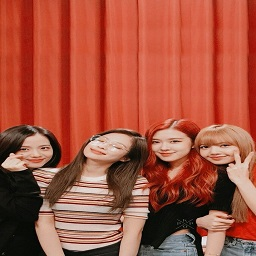

In [ ]:
imgfile="/content/drive/MyDrive/ganchanh/data/my_photos/5.jpeg" #이미지 경로설정
lineimg=cv2.imread(imgfile, cv2.IMREAD_COLOR) #이미지를 컬러로 가져옴 
cv2_imshow(lineimg) 

#12. GAN 적용시작


In [ ]:
test_my_photo= tf.data.Dataset.list_files("/content/drive/MyDrive/ganchanh/data/my_photos/5.jpeg") #test할 my_photo가지고 옴
test_my_photo = test_my_photo.map(preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
#위에서 사용한 학습함수인 generator_images를 좀 변환한 함수!
def out_images(model, test_input):
  prediction = model(test_input) #학습한 모델으로 test_input 변환해줌
    
  plt.figure(figsize=(6, 6)) 

  display_list = [test_input[0], prediction[0]] #test_input이 원본이고 prediction이 gan학습한 이미지
  original=test_input[0] #original에 test_input 저장(마지막에 return할 수 있게 따로 선언한 것)
  ganout=prediction[0] #ganout에 prediction 저장(마지막에 return할 수 있게 따로 선언한 것)
  title = ['Input Image', 'Predicted Image'] #여기서부터 걍 출력

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()
  return original,ganout

## 원본이미지와 GAN을 적용한 이미지를 따로 저장

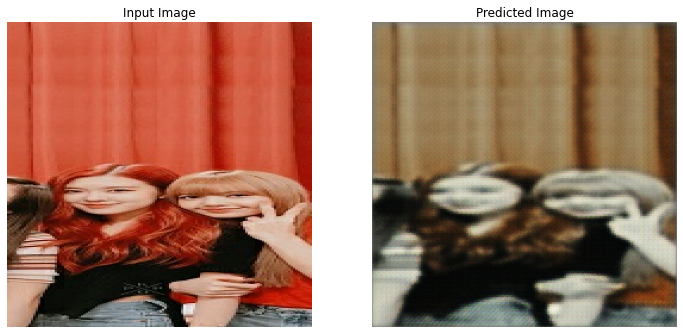

True

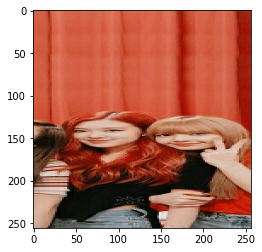

In [ ]:
for inp in test_my_photo.take(1): #이미지 출력, 원본%gan학습
  original,ganout=out_images(generator_g, inp)

#original출력해보기
plt.imshow(original* 0.5 + 0.5)
original=np.array(original* 0.5 + 0.5)
original= cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
cv2.imwrite("/content/drive/MyDrive/ganchanh/data/applygan/original.jpeg",255*original) #drive에 있는 applygan에 original로 사진 저장

True

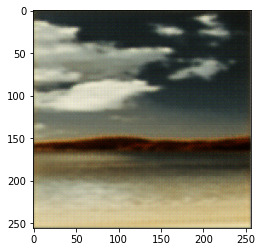

In [ ]:
#gan적용한 이미지 출력해보기
plt.imshow(ganout* 0.5 + 0.5)
ganout=np.array(ganout* 0.5 + 0.5)
ganout= cv2.cvtColor(ganout, cv2.COLOR_BGR2RGB)
cv2.imwrite("/content/drive/MyDrive/ganchanh/data/applygan/ganout.jpeg",255*ganout) #drive에 있는 applygan에 ganout으로 사진 저장

## 원본 이미지에서 detection

Number of objects found: 0 

no segmentation
x[]:  []
y[]:  []
x[]:  []
y[]:  []


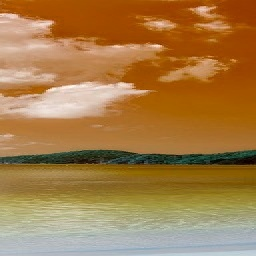

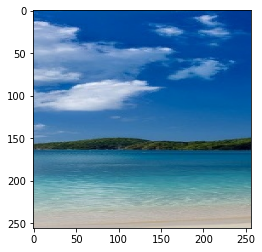

In [ ]:
#google vision api 사용한 코드(for segmentation)
import io 
import os 
from google.cloud import vision 
client = vision.ImageAnnotatorClient() 
file_name = os.path.abspath('/content/drive/MyDrive/ganchanh/data/applygan/original.jpeg') #orginal 이미지로 우선 segmentation을 해줌
image_test=tf.data.Dataset.list_files(('/content/drive/MyDrive/ganchanh/data/applygan/original.jpeg') )
image_test = image_test.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

x=[]
y=[]

# Loads the image into memory 
with io.open(file_name, 'rb') as image_file:
    content = image_file.read() 
image = vision.Image(content=content)
objects = client.object_localization(image=image).localized_object_annotations

print('Number of objects found: {} \n'.format(len(objects)))
for object_ in objects:
    print('{} (confidence: {})\n'.format(object_.name, object_.score))
    #print('Normalized bounding polygon vertices: ')
    for vertex in object_.bounding_poly.normalized_vertices:
        x.append(vertex.x)
        y.append(vertex.y)

if(len(objects)==0):
    print("no segmentation")

print("x[]: ",x)
print("y[]: ",y)

#nomalizedvertex를 vertex로
for i in range(len(x)):
    x[i]=int(x[i]*255)
    y[i]=int(y[i]*255)
print("x[]: ",x)
print("y[]: ",y)

imgfile='/content/drive/MyDrive/ganchanh/data/applygan/original.jpeg'
lineimg=cv2.imread(imgfile, cv2.IMREAD_COLOR)
lineimg= cv2.cvtColor(lineimg, cv2.COLOR_BGR2RGB)
cv2_imshow(lineimg)

#범위 빨간선으로 설정
for i in range(len(objects)):
    for j in range(len(x)):
        if(j%4==0):
            lineimg = cv2.rectangle(lineimg, (x[j],y[j]), (x[j+2],y[j+2]), (255, 0, 0), 3)
            #print("j",j)
            j=j+3

plt.imshow(lineimg)

## detection한 범위를 gan을 적용한 이미지에 표시

위 코드에서 찾은 x,y리스트를 사용

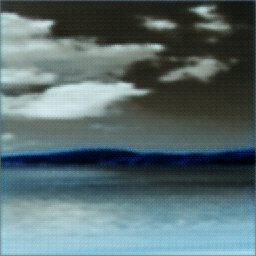

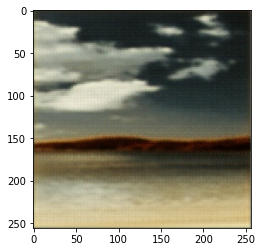

In [ ]:
imgfile='/content/drive/MyDrive/ganchanh/data/applygan/ganout.jpeg' #gan 적용한 이미지 불러옴
ganout=cv2.imread(imgfile, cv2.IMREAD_COLOR)
ganout= cv2.cvtColor(ganout, cv2.COLOR_BGR2RGB)
cv2_imshow(ganout)

for i in range(len(objects)): #gan 적용한 이미지에 빨간 박스 표시
    for j in range(len(x)):
        if(j%4==0):
            ganout = cv2.rectangle(ganout, (x[j],y[j]), (x[j+2],y[j+2]), (255, 0, 0), 3)
            #print("j",j)
            j=j+3            
plt.imshow(ganout)

## 이미지 합치기

In [ ]:
 imageFile='/content/drive/MyDrive/ganchanh/data/applygan/original.jpeg'
img = cv2.imread(imageFile, cv2.IMREAD_COLOR) #원본이미지는 img라고 하고
imageFile='/content/drive/MyDrive/ganchanh/data/applygan/ganout.jpeg'
ganimg=cv2.imread(imageFile, cv2.IMREAD_COLOR) #gan을 적용한 이미지는 ganimg라 함
#둘 다 컬러로 가져오려고 cv2.IMREAD_COLOR 해주는 것


print(len(objects)) #object개수
print(x) #x리스트
print(y) #y리스트

#i번째 segmentation을 변환하고 싶으면 4*(i-1) 
i=4
#왜인지는 모르겠지만...픽셀값이 [y,x]일케 들어가있음
#detection 범위에 맞춰서 원본이미지 픽셀을 gan을 적용한 이미지 픽셀로 바꿔줌
for yy in range(y[i],y[i+2]):
    for xx in range(x[i],x[i+1]):
        img[yy,xx]=ganimg[yy,xx]


img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#cv2_imshow(img)
plt.imshow(img) #이미지 출력~!

0
[]
[]


IndexError: ignored

https://cloud.google.com/vision/docs/object-localizer

https://cloud.google.com/vision/docs/samples/vision-localize-objects-gcs-beta?hl=ko